In [194]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from typing import List
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [193]:
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

pandas==1.2.3
numpy==1.19.2
seaborn==0.9.0


### Heart decease dataset analysis

In [85]:
df = pd.read_csv('../dataset/heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


Target: 1 - deceased; 0 - healthy

In [3]:
# Missing values -> no missing values
df.isnull().sum().sum()

0

In [4]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [189]:
df.nunique()
#cols with unique vals <= 5 are categorical

age          41
sex           2
cp            4
trestbps     49
chol        152
fbs           2
restecg       3
thalach      91
exang         2
oldpeak      40
slope         3
ca            5
thal          4
target        2
dtype: int64

In [22]:
deceased = np.round(np.sum(df['target']==1) / len(df) * 100)
healthy = 100 - deceased
print("{deceased}% deceased, {healthy}% healthy in dataset".format(deceased=deceased, healthy=healthy))

54.0% deceased, 46.0% healthy in dataset


In [32]:
corr_matrix = df.corr()

Text(0.5, 1.0, 'Correlation between features in dataset')

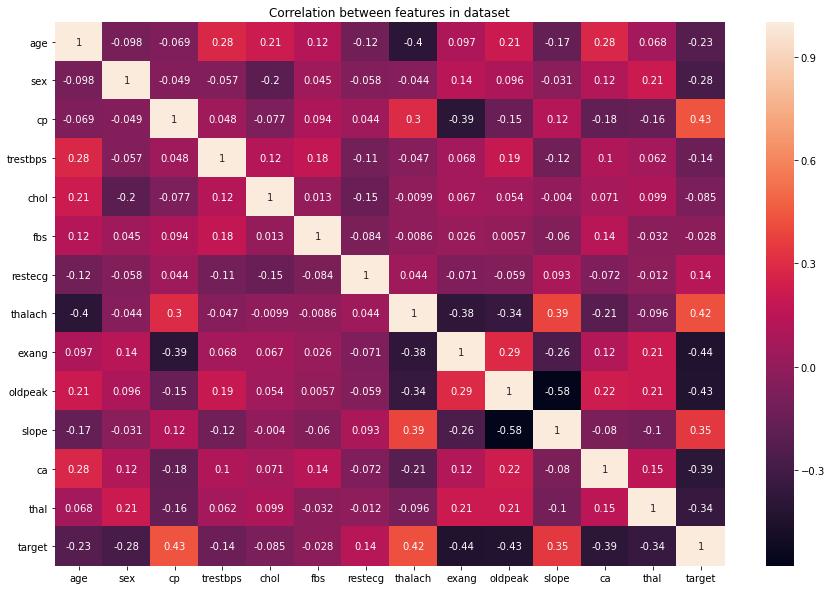

In [33]:
plt.figure(figsize=(15,10))
sns.heatmap(corr_matrix, annot=True)
plt.title('Correlation between features in dataset')

In [41]:
corr_rating = corr_matrix['target'].sort_values(ascending=False)
print(corr_rating)

target      1.000000
cp          0.433798
thalach     0.421741
slope       0.345877
restecg     0.137230
fbs        -0.028046
chol       -0.085239
trestbps   -0.144931
age        -0.225439
sex        -0.280937
thal       -0.344029
ca         -0.391724
oldpeak    -0.430696
exang      -0.436757
Name: target, dtype: float64


In [121]:
# Meaningfull features
cols_drop = [feature for feature in list(corr_rating.index) if (corr_rating[feature] < 0)]
cols_drop

['fbs', 'chol', 'trestbps', 'age', 'sex', 'thal', 'ca', 'oldpeak', 'exang']

In [188]:
[feature for feature in list(corr_rating.index) if (corr_rating[feature] > 0)]

['target', 'cp', 'thalach', 'slope', 'restecg']

In [197]:
cat_cols = ['cp', 'slope', 'restecg']
num_cols = ['thalach']

In [201]:
def transform_data(df: pd.DataFrame, cols_drop: List[str]=[]) -> np.ndarray:
    transformed_df = df.copy()
    transformed_df.drop(cols_drop, axis=1, inplace=True)
    for col in cat_cols:
        transformed_df[col] = transformed_df[col].astype('category')
        transformed_df = pd.concat([transformed_df.drop(
            col, axis=1), pd.get_dummies(transformed_df[col], prefix=col)], axis=1)
    scaler = StandardScaler()
    transformed_df[num_cols] = scaler.fit_transform(transformed_df[num_cols])
    x = transformed_df.copy()
    y = x['target'].copy()
    y = y.to_numpy()
    x.drop('target', axis=1, inplace=True)   
    return x, y

In [203]:
features, target = transform_data(df, cols_drop)

In [165]:
type(features)
type(target)

numpy.ndarray

### Classification model test

In [204]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

### Model 1: KNeighborsClassifier

In [206]:
model_knn = KNeighborsClassifier()
model_knn.fit(x_train, y_train)
preds_knn = np.round(model_knn.predict(x_test))

print(accuracy_score(y_test, preds_knn))

0.819672131147541


### Model 2: RandomForest

In [207]:
model_rf = RandomForestClassifier(n_estimators=500, max_depth = 6)
model_rf.fit(x_train, y_train)
preds_rf = np.round(model_rf.predict(x_test))
print(accuracy_score(y_test, preds_rf))

0.8360655737704918
